# <center> Analyze keyword using interactive stft and mel spectrum

# Import packages and widgets

In [4]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Read audio file

In [6]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_waveform(file_path):
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform

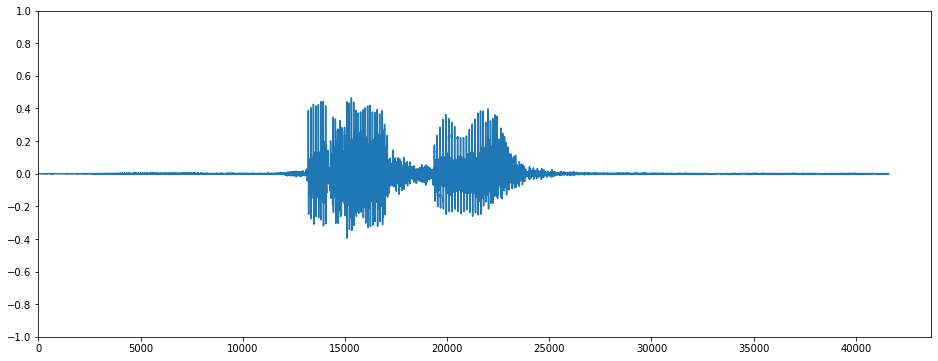

In [16]:
waveform = get_waveform('./audio_sample/M_Hello.Jio_vivo1714_IVUGW4TGBYCADIA6_1902270957008723_16k.wav')
%matplotlib inline

fig, axis = plt.subplots(1, figsize=(16, 6))
axis.plot(waveform.numpy())
axis.set_xlim(0)
axis.set_yticks(np.arange(-1.0, 1.1, 0.2))

# Plot interactive stft spectrum

In [70]:
def get_spectrogram(waveform, window_len, hop_len):
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(
        waveform, frame_length=window_len, frame_step=hop_len)

    spectrogram = tf.abs(spectrogram)
    return spectrogram

In [71]:
%matplotlib inline

def plot_spectrogram(waveform, window_len, hop_len):
    spectrogram = get_spectrogram(waveform, window_len, hop_len)
    print('NumBins = ', spectrogram.shape[1])
    log_spec = np.log(spectrogram.numpy().T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(log_spec), num=width, dtype=int)
    Y = range(height)
    
#     plt.pcolormesh(X, Y, log_spec)
    fig, axis = plt.subplots(1, figsize=(16, 6))
    axis.pcolormesh(X, Y, log_spec, shading='auto')
    plt.show()

ww = interactive(plot_spectrogram, waveform = fixed(waveform),
                 window_len=IntSlider(value=128, min=32, max=4096, step=32, continuous_update=False),
                hop_len=IntSlider(value=160, min=100, max=200, step=10, continuous_update=False))
ww

interactive(children=(IntSlider(value=128, continuous_update=False, description='window_len', max=4096, min=32…

# Plot interactive mel spectrum

In [66]:
def get_log_mel_spectrogram(waveform, window_len, hop_len, mel_bands):
  """Compute log mel spectrogram of a 1-D waveform."""
  with tf.name_scope('log_mel_features'):
    sample_rate = 16000
#     mel_bands = 64
    mel_min_hz = 125
    mel_max_hz = 7500
    log_offset = 0.001
    # waveform has shape [<# samples>]
    
    magnitude_spectrogram = get_spectrogram(waveform, window_len, hop_len)

    num_spectrogram_bins = magnitude_spectrogram.shape[1]
    print('NumBins = ', num_spectrogram_bins)
    
    # Convert spectrogram into log mel spectrogram.
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=mel_bands,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=sample_rate,
        lower_edge_hertz=mel_min_hz,
        upper_edge_hertz=mel_max_hz)
    mel_spectrogram = tf.matmul(
      magnitude_spectrogram, linear_to_mel_weight_matrix)
    log_mel_spectrogram = tf.math.log(mel_spectrogram + log_offset)

    return log_mel_spectrogram

In [69]:
%matplotlib inline

def plot_log_mel_spectrogram(waveform, window_len, hop_len, mel_bands):
    log_mel_spec = get_log_mel_spectrogram(waveform, window_len, hop_len, mel_bands)
    log_mel_spec = log_mel_spec.numpy().T
    height = log_mel_spec.shape[0]
    width = log_mel_spec.shape[1]
    X = np.linspace(0, np.size(log_mel_spec), num=width, dtype=int)
    Y = range(height)
    
#     plt.pcolormesh(X, Y, log_spec)
    fig, axis = plt.subplots(1, figsize=(16, 6))
    axis.pcolormesh(X, Y, log_mel_spec, shading='auto')
    plt.show()

ww = interactive(plot_log_mel_spectrogram, waveform = fixed(waveform),
                 window_len=IntSlider(value=256, min=128, max=2048, step=32, continuous_update=False),
                hop_len=fixed(160),
                mel_bands=IntSlider(value=64, min=32, max=128, step=1, continuous_update=False))
ww

interactive(children=(IntSlider(value=256, continuous_update=False, description='window_len', max=2048, min=12…